# Feature engineering with Pandas

## Импорты 

In [26]:
import yaml

with open('C:/Users/Zver/Desktop/uni/AIF/Practice/spbu-ai-fundamentals-main/practicum_5/config.yaml', 'r') as f:
    cfg = yaml.safe_load(f)

In [27]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [28]:

# from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
# from xgboost import XGBRegressor

In [29]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [30]:
!pip install category_encoders --user

In [31]:
from sklearn.impute import SimpleImputer
import category_encoders as ce
from category_encoders import wrapper

### Общая информация

In [32]:
train_df = pd.read_csv(cfg['house_pricing']['train_dataset'])
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [33]:
test_df = pd.read_csv(cfg['house_pricing']['test_dataset'])
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Не все столбцы здесь выведены. Их список мы можем получить, используя аттрибут `columns`:

In [34]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Почистим данные в нескольких столбцах, основываясь на data_description

In [35]:
train_df["Exterior2nd"] = train_df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
train_df["GarageYrBlt"] = train_df["GarageYrBlt"].where(train_df.GarageYrBlt <= 2010, train_df.YearBuilt)
    # Names beginning with numbers are awkward to work with
train_df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
        }, inplace=True,)

In [36]:
cat_df = train_df.select_dtypes(include=['object'])

In [37]:
num_df = train_df.select_dtypes(exclude=['object'])


In [38]:
num_сols_with_missing = [col for col in num_df.columns 
                                 if num_df[col].isnull().any()]


In [39]:
cat_сols_with_missing = [col for col in cat_df.columns 
                                 if cat_df[col].isnull().any()]

In [40]:
train_df[cat_сols_with_missing] = train_df[cat_сols_with_missing].fillna('NAN')

In [41]:
train_df.drop(['GarageYrBlt','TotRmsAbvGrd','FirstFlrSF','GarageCars'], axis=1, inplace=True)

In [42]:
my_imputer = SimpleImputer()

train_df[num_сols_with_missing] = my_imputer.fit_transform(train_df[num_сols_with_missing])

In [43]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NAN,Reg,Lvl,AllPub,...,0,NAN,NAN,NAN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NAN,Reg,Lvl,AllPub,...,0,NAN,NAN,NAN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NAN,IR1,Lvl,AllPub,...,0,NAN,NAN,NAN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NAN,IR1,Lvl,AllPub,...,0,NAN,NAN,NAN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NAN,IR1,Lvl,AllPub,...,0,NAN,NAN,NAN,0,12,2008,WD,Normal,250000


In [44]:
cat_df = train_df.select_dtypes(include=['object'])
cat_df.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [45]:
train_df.LandContour.value_counts()

LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: count, dtype: int64

В нашем наборе достаточно много категориальных признаков, и использовать их в таком виде, как они представлены в датасете, скорее всего нельзя. Это связано с тем, что модели в большинстве своем работают с евклидовыми или метрическими пространствами. Для перевода категориальных признаков в них используются различные техники, рассмотрим некоторые из них

# Label Encoding

Естественным решением такой проблемы было бы однозначное отображение каждого значения в уникальное число. К примеру, мы могли бы преобразовать признак Street так: Pave в 0, а Grvl в 1. Эту простую операцию приходится делать часто, поэтому в модуле sklearn.preprocessing  именно для этой задачи реализован класс LabelEncoder. 

Метод fit этого класса находит все уникальные значения признака и строит таблицу для соответствия каждой категории некоторому числу, а метод transform непосредственно преобразует значения в числа. После fit у label_encoder будет доступно поле classes_, содержащее все уникальные значения.

<Axes: ylabel='LandContour'>

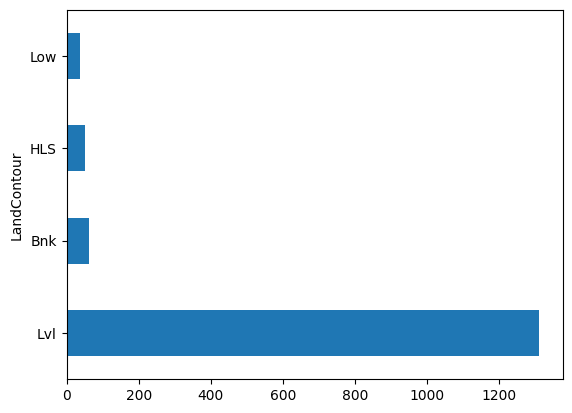

In [46]:
train_df.LandContour.value_counts().plot.barh()

<Axes: ylabel='Count'>

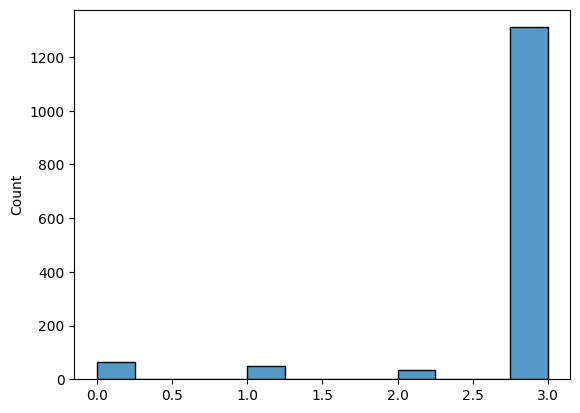

In [47]:
label_encoder = LabelEncoder()

encoded_neigh = pd.Series(label_encoder.fit_transform(train_df['LandContour']))
sns.histplot(encoded_neigh )

<Axes: ylabel='Count'>

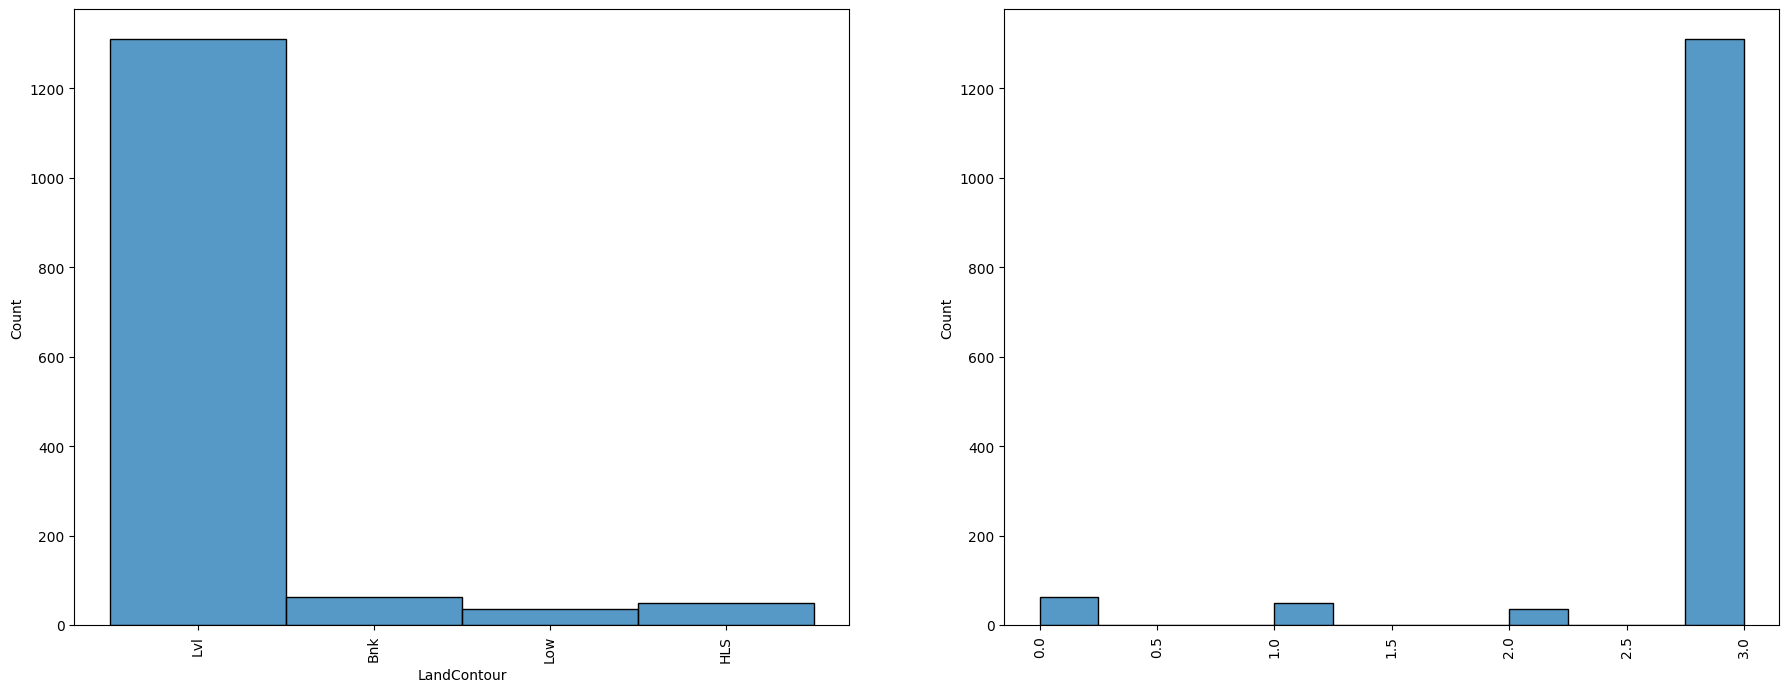

In [48]:
fig, axes = plt.subplots(1,2,figsize=(22,8))
axes[0].tick_params(axis='x', rotation=90)
sns.histplot(train_df['LandContour'], ax=axes[0])
axes[1].tick_params(axis='x', rotation=90)
sns.histplot(encoded_neigh, ax=axes[1] )

In [49]:
print(dict(enumerate(label_encoder.classes_)))

{0: 'Bnk', 1: 'HLS', 2: 'Low', 3: 'Lvl'}


Вопрос: Что произойдет, если у нас появятся данные с другими категориями? LabelEncoder выдаст ошибку, что в словаре нет такой категории

In [50]:
label_encoder.transform(train_df['LandContour'].replace('Low', 'low'))

ValueError: y contains previously unseen labels: 'low'

Таким образом, при использовании этого метода нужно быть уверенным, что признак не может принимать неизвестных ранее значений.  Вопрос: как можно эту проблему решить?

Основная проблема такого представления заключается даже не в этом, а в том, что числовой код создал евклидово представление для данных. Это значит, что теперь можно вычесть "Low" из "Bnk" и тд. Поэтому, например, методы, основанные на расстоянии, становятся больше неприменимы.

LabelEncoding не принимает во внимание порядок переменных. Поэтому, если на самом деле известно, в каком порядке должны располагаться категории, лучше использовать другой метод энкодинга, например, порядковый. 


**Задание**: Закодируйте все категориальные переменные джля обучающего и тестового датасетов с помощью Label Encoding. При этом: сначала обучите на обучающем и примените на тестовом, потом наоборот. Появятся ли ошибки из-за неизвестных категорий? 
Найдите параметр, контролирующий это поведение. 

In [51]:
categorical_cols = train_df.select_dtypes(include='object').columns.tolist()  # Автоматически определяет категориальные столбцы

def label_encode_train_test(train_df, test_df, columns):

    for col in columns:
        le = LabelEncoder()
        le.fit(train_df[col])
        train_df[col + '_encoded_1'] = le.transform(train_df[col])
        try:
            test_df[col + '_encoded_1'] = le.transform(test_df[col])
        except ValueError as e:
            print(f"Ошибка в столбце {col}: {e}")

            # Обработка неизвестных категорий: заменяем на NaN или другое значение
            # Здесь заменяем на -1.  Важно выбрать адекватное значение!
            test_df[col + '_encoded_1'] = test_df[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

    return train_df, test_df


# 2. Обучение на тестовом и применение на обучающем

def label_encode_test_train(train_df, test_df, columns):
    for col in columns:
        le = LabelEncoder()
        le.fit(test_df[col])
        test_df[col + '_encoded_2'] = le.transform(test_df[col])
        try:
            train_df[col + '_encoded_2'] = le.transform(train_df[col])
        except ValueError as e:
            print(f"Ошибка в столбце {col}: {e}")

            # Обработка неизвестных категорий: заменяем на NaN или другое значение
            train_df[col + '_encoded_2'] = train_df[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    return train_df, test_df

train_df, test_df = label_encode_train_test(train_df.copy(), test_df.copy(), categorical_cols)
train_df, test_df = label_encode_test_train(train_df.copy(), test_df.copy(), categorical_cols)

print("Обучающий датасет:")
train_df.head()

Ошибка в столбце MSZoning: y contains previously unseen labels: nan
Ошибка в столбце Alley: y contains previously unseen labels: nan
Ошибка в столбце Utilities: y contains previously unseen labels: nan
Ошибка в столбце Exterior1st: y contains previously unseen labels: nan
Ошибка в столбце Exterior2nd: y contains previously unseen labels: 'Brk Cmn'
Ошибка в столбце MasVnrType: y contains previously unseen labels: nan
Ошибка в столбце BsmtQual: y contains previously unseen labels: nan
Ошибка в столбце BsmtCond: y contains previously unseen labels: nan
Ошибка в столбце BsmtExposure: y contains previously unseen labels: nan
Ошибка в столбце BsmtFinType1: y contains previously unseen labels: nan
Ошибка в столбце BsmtFinType2: y contains previously unseen labels: nan
Ошибка в столбце KitchenQual: y contains previously unseen labels: nan
Ошибка в столбце Functional: y contains previously unseen labels: nan
Ошибка в столбце FireplaceQu: y contains previously unseen labels: nan
Ошибка в столбце

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,GarageType_encoded_2,GarageFinish_encoded_2,GarageQual_encoded_2,GarageCond_encoded_2,PavedDrive_encoded_2,PoolQC_encoded_2,Fence_encoded_2,MiscFeature_encoded_2,SaleType_encoded_2,SaleCondition_encoded_2
0,1,60,RL,65.0,8450,Pave,NAN,Reg,Lvl,AllPub,...,1,1,3,4,2,-1,-1,-1,8,4
1,2,20,RL,80.0,9600,Pave,NAN,Reg,Lvl,AllPub,...,1,1,3,4,2,-1,-1,-1,8,4
2,3,60,RL,68.0,11250,Pave,NAN,IR1,Lvl,AllPub,...,1,1,3,4,2,-1,-1,-1,8,4
3,4,70,RL,60.0,9550,Pave,NAN,IR1,Lvl,AllPub,...,5,2,3,4,2,-1,-1,-1,8,0
4,5,60,RL,84.0,14260,Pave,NAN,IR1,Lvl,AllPub,...,1,1,3,4,2,-1,-1,-1,8,4


In [52]:
print("\nТестовый датасет:")
test_df.head()


Тестовый датасет:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,GarageType_encoded_2,GarageFinish_encoded_2,GarageQual_encoded_2,GarageCond_encoded_2,PavedDrive_encoded_2,PoolQC_encoded_2,Fence_encoded_2,MiscFeature_encoded_2,SaleType_encoded_2,SaleCondition_encoded_2
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,1,2,3,4,2,2,2,3,8,4
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,1,2,3,4,2,2,4,0,8,4
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,1,0,3,4,2,2,2,3,8,4
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,1,0,3,4,2,2,4,3,8,4
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,1,1,3,4,2,2,4,3,8,4


**Задание**: Используйте Ordinal Encoding для признака MS_Zoning. Задайте категории автоматически и подайте как параметр. Будут ли они закодированы одинаково или нет?

In [53]:
from sklearn.preprocessing import OrdinalEncoder
import warnings

categories = [train_df['MSZoning'].unique()]
oe = OrdinalEncoder(categories=categories, handle_unknown='use_encoded_value', unknown_value=-1)
train_df['MSZoning_ordinal'] = oe.fit_transform(train_df[['MSZoning']])
test_df['MSZoning_ordinal'] = oe.transform(test_df[['MSZoning']])
warnings.filterwarnings("ignore", category=UserWarning)

print("Обучающий датасет:")
print(train_df[['MSZoning', 'MSZoning_ordinal']].head())
print("\nТестовый датасет:")
print(test_df[['MSZoning', 'MSZoning_ordinal']].head())

print("\nПроверка кодировки:")
unique_categories = train_df['MSZoning'].unique()
for cat in unique_categories:
    train_encoded = oe.transform([[cat]])[0][0]
    test_encoded = oe.transform([[cat]])[0][0]
    print(f"Категория: {cat}, Код в train: {train_encoded}, Код в test: {test_encoded}")


# Дополнительные пояснения:

# * handle_unknown='use_encoded_value': указывает, что делать с неизвестными категориями.
# * unknown_value=-1: определяет код, который будет присвоен неизвестным категориям.

# Вопрос:
# * Будут ли они закодированы одинаково или нет?
# Ответ: Да, значения в train и test наборе будут закодированы одинаково.

Обучающий датасет:
  MSZoning  MSZoning_ordinal
0       RL               0.0
1       RL               0.0
2       RL               0.0
3       RL               0.0
4       RL               0.0

Тестовый датасет:
  MSZoning  MSZoning_ordinal
0       RH               4.0
1       RL               0.0
2       RL               0.0
3       RL               0.0
4       RL               0.0

Проверка кодировки:
Категория: RL, Код в train: 0.0, Код в test: 0.0
Категория: RM, Код в train: 1.0, Код в test: 1.0
Категория: C (all), Код в train: 2.0, Код в test: 2.0
Категория: FV, Код в train: 3.0, Код в test: 3.0
Категория: RH, Код в train: 4.0, Код в test: 4.0


# One Hot encoding 

One Hot encoding является наиболее распространенным подходом для преобразования категориальных признаков, и он работает очень хорошо, если ваша категориальная переменная принимает небольшое количество значений (т.е. вы, как правило, не будете этого делать для переменных, которые принимают более 15 различных значений)

Предположим, что некоторый признак может принимать 10 разных значений. В этом случае One Hot Encoding подразумевает создание 10 признаков, все из которых равны нулю за исключением одного. На позицию, соответствующую численному значению признака мы помещаем 1.
Этот метод реализован в sklearn.preprocessing в классе OneHotEncoder. По умолчанию OneHotEncoder преобразует данные в разреженную матрицу, чтобы не расходовать память на хранение многочисленных нулей. Однако в нашем случае размер данных не является проблемой, поэтому мы будем использовать "плотное" представление.


In [54]:
onehot_encoder = OneHotEncoder(sparse_output=False)

encoded_categorical_columns = pd.DataFrame(onehot_encoder.fit_transform(cat_df))
encoded_categorical_columns.head()


,0,1,2,3,4,5,6,7,8,9,...,257,258,259,260,261,262,263,264,265,266
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Как видно, у нас получилось  268 столбцов - именно столько уникальных значений могут принимать категориальные столбцы. Список категорий можно посмотреть с помощью `onehot_encoder.categories_`

In [55]:
onehot_encoder.categories_

[array(['C (all)', 'FV', 'RH', 'RL', 'RM'], dtype=object),
 array(['Grvl', 'Pave'], dtype=object),
 array(['Grvl', 'NAN', 'Pave'], dtype=object),
 array(['IR1', 'IR2', 'IR3', 'Reg'], dtype=object),
 array(['Bnk', 'HLS', 'Low', 'Lvl'], dtype=object),
 array(['AllPub', 'NoSeWa'], dtype=object),
 array(['Corner', 'CulDSac', 'FR2', 'FR3', 'Inside'], dtype=object),
 array(['Gtl', 'Mod', 'Sev'], dtype=object),
 array(['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr',
        'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel',
        'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown',
        'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber',
        'Veenker'], dtype=object),
 array(['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNe',
        'RRNn'], dtype=object),
 array(['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNn'],
       dtype=object),
 array(['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE'], dtype=obj

Кроме того, можно сразу удалить категории, которые встречаются редко. Это можно сделать, задав значение параметра min_frequency

In [56]:
onehot_encoder = OneHotEncoder(sparse_output=False, min_frequency=0.3)
encoded_categorical_columns = pd.DataFrame(onehot_encoder.fit_transform(cat_df))
encoded_categorical_columns.head()


,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


Кроме sklearn Pandas предлагает удобную функцию get_dummies для получения One Hot Encoding-а. Его минус в том, что нельзя с помощью transform менять новые наборы данных.

In [57]:
pd.get_dummies(cat_df).head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_NAN,Alley_Pave,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,False,False,False,True,False,False,True,False,True,False,...,False,False,False,True,False,False,False,False,True,False
1,False,False,False,True,False,False,True,False,True,False,...,False,False,False,True,False,False,False,False,True,False
2,False,False,False,True,False,False,True,False,True,False,...,False,False,False,True,False,False,False,False,True,False
3,False,False,False,True,False,False,True,False,True,False,...,False,False,False,True,True,False,False,False,False,False
4,False,False,False,True,False,False,True,False,True,False,...,False,False,False,True,False,False,False,False,True,False


Используя OneHotEncoder, мы можем четко контролировать, что происходит, когда он сталкивается с новой категорией. Если мы думаем, что это невозможно, то мы можем сказать ему, чтобы он выдал ошибку с handle_unknown="error"; в противном случае мы можем указать ему просто установить значения во всех "известных" столбцах в 0, с помощью handle_unknown="ignore".

In [58]:
temp_df = cat_df.copy()
temp_df['LandContour'] = temp_df['LandContour'].replace('Low', 'low')

In [59]:
onehot_encoder = OneHotEncoder(sparse_output=False, min_frequency=0.3, handle_unknown="ignore")
onehot_encoder.fit(cat_df)
encoded_categorical_columns = pd.DataFrame(onehot_encoder.transform(temp_df))
encoded_categorical_columns.head()


,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


Как видно, признаков получается очень и очень много (столько же, сколько и категорий). Однако есть способ использовать более плотное представление, а именно бинарное. Этот метод комбинирует LabelEncoding и BinaryEncoding. Обнако, широко он не используется. Пофантазируйте, почему это может быть?

**Задание**: Определите, сколько столбцов получится после Binary Encoding.

In [60]:
import numpy as np

def count_binary_encoded_columns_for_all(df):
    categorical_columns = df.select_dtypes(include='object').columns
    column_counts = {}
    for col in categorical_columns:
        n_categories = df[col].nunique()
        n_columns = int(np.ceil(np.log2(n_categories)))
        column_counts[col] = n_columns
    return column_counts

binary_encoded_counts = count_binary_encoded_columns_for_all(cat_df)

print("Количество столбцов после бинарного кодирования для каждого столбца:")
for column, count in binary_encoded_counts.items():
    print(f"'{column}': {count} столбцов")

total_binary_columns = sum(binary_encoded_counts.values())
print(f"\nОбщее количество столбцов после бинарного кодирования всех категориальных столбцов: {total_binary_columns}")

Количество столбцов после бинарного кодирования для каждого столбца:
'MSZoning': 3 столбцов
'Street': 1 столбцов
'Alley': 2 столбцов
'LotShape': 2 столбцов
'LandContour': 2 столбцов
'Utilities': 1 столбцов
'LotConfig': 3 столбцов
'LandSlope': 2 столбцов
'Neighborhood': 5 столбцов
'Condition1': 4 столбцов
'Condition2': 3 столбцов
'BldgType': 3 столбцов
'HouseStyle': 3 столбцов
'RoofStyle': 3 столбцов
'RoofMatl': 3 столбцов
'Exterior1st': 4 столбцов
'Exterior2nd': 4 столбцов
'MasVnrType': 2 столбцов
'ExterQual': 2 столбцов
'ExterCond': 3 столбцов
'Foundation': 3 столбцов
'BsmtQual': 3 столбцов
'BsmtCond': 3 столбцов
'BsmtExposure': 3 столбцов
'BsmtFinType1': 3 столбцов
'BsmtFinType2': 3 столбцов
'Heating': 3 столбцов
'HeatingQC': 3 столбцов
'CentralAir': 1 столбцов
'Electrical': 3 столбцов
'KitchenQual': 2 столбцов
'Functional': 3 столбцов
'FireplaceQu': 3 столбцов
'GarageType': 3 столбцов
'GarageFinish': 2 столбцов
'GarageQual': 3 столбцов
'GarageCond': 3 столбцов
'PavedDrive': 2 столбц

# Target Encoding

Target Encoding аналогичен label encoding-у, за исключением того, что здесь значения коррелируют непосредственно с целевой переменной. Среднее значение кода для каждой категории в лейбле элемента определяется средним значением целевой переменной на обучающих данных. Этот метод кодирования выявляет связь между аналогичными категориями, но отношения ограничены внутри категорий и цели.

Преимущество этого метода кодирования заключается в том, что оно не влияет на объем данных и помогает в более быстром обучении. Часто обеспечивает более высокую точность (иногда резко высокую точность) из-за прямой корреляции между закодированной переменной и целевой.


Самый простой способ сделать такое кодирование - присвоить категории среднее значение таргета для нее. Это обучаемый метод, т.к. мы используем выходы нашего моделирования для построения кодирования. Кстати, на самом деле необяхательно использовать настоящий таргет)

**Задание**: Покажите, что происходит, когда этот метод применяется к постоянному предиктору.

In [64]:
def target_encode(df, column_name, target_name):
    encoded_column = df.groupby(column_name)[target_name].transform('mean')
    return encoded_column

constant_cols = [col for col in train_df.columns if train_df[col].nunique() == 1]
print("Constant Predictors:", constant_cols)

if constant_cols:
    first_constant_col = constant_cols[0]
    target_name = 'SalePrice'
    train_df[first_constant_col + '_encoded'] = target_encode(train_df, first_constant_col, target_name)
    print("\nTarget Encoded DataFrame (first few rows):")
    print(train_df[[first_constant_col, first_constant_col + '_encoded']].head())
    print(f"\nUnique value in {first_constant_col}:", train_df[first_constant_col].unique())
    print(f"Encoded value in {first_constant_col}_encoded:", train_df[first_constant_col + '_encoded'].unique())

else:
    print("\nNo constant predictors found in the training data.")

Constant Predictors: []

No constant predictors found in the training data.


Однако такая кодировка создает несколько проблем. Во-первых, неизвестные категории. Может быть так, что какие-то категории просто изначально не попали в данные, а может, что их и не может быть (знакомо?). Чем можно закодировать такие категории?

Во-вторых, это редкие категории. В тех случаях, когда какая-либо категория встречается в наборе данных лишь несколько раз, любые статистические данные, рассчитанные по ней, вряд ли будут очень точными. В нашем наборе данных LandContour значение Low появляется меньше 50 раз. "Средняя" цена, которую мы рассчитали, может быть не очень репрезентативной для зданий с таким значением, которые мы можем увидеть в будущем. Target Encoding редких категорий может сделать переобучение более вероятным. 

Решением этих проблем является добавление сглаживания. Идея состоит в том, чтобы смешать среднее значение по категории с общим средним значением. Редкие категории получают меньший вес в новом значении, в то время как недостающие категории просто получают среднее по всем остальным данным.

Вопрос: А как применить это  кодирование к классификации? 

Например, в category encoders используется формула для рассчета веса 
`weight = 1/(1+exp(-(n–k)/f))`, где k - параметр minimal_samples_per_leaf, f - параметр smoothing

In [65]:
target_encoder = ce.TargetEncoder()
encoded = target_encoder.fit_transform(train_df['LandContour'], train_df["SalePrice"])
encoded.value_counts()

LandContour  
180183.746758    1311
143610.333996      63
229133.586417      50
199841.223430      36
Name: count, dtype: int64

In [66]:
target_encoder = ce.TargetEncoder(smoothing=100)
encoded = target_encoder.fit_transform(train_df['LandContour'], train_df["SalePrice"])
encoded.value_counts()

LandContour  
180183.748582    1311
158008.800772      63
209995.307999      50
193198.814592      36
Name: count, dtype: int64

По умолчанию, когда встречается неизвестное значение, то оно кодируется средним по всему датасету.

In [67]:
temp_df = train_df.copy()
temp_df['LandContour'] = temp_df['LandContour'].replace('Low', 'low')
encoded = target_encoder.transform(temp_df['LandContour'])
encoded.value_counts()

LandContour  
180183.748582    1311
158008.800772      63
209995.307999      50
180921.195890      36
Name: count, dtype: int64

Очень большой минус target encoding - это "протекание" таргета, так как мы используем его значения для каждого элемента через аггрегацию. С этим можно бороться несколькими путями, например, усилить регуляризацию, добавлять шум, использовать K-Fold Target Encoding.

Идея схожа с перекрестной валидацией. Мы делим данные на K-стратифицированные или случайные группы, заменяем наблюдения, присутствующие в M-й группе, на среднее целевое значение данных из всех остальных групп, кроме M-й. Мы в основном пытаемся использовать все данные, предоставленные нам, и не допускать утечки информации из целевой переменной, используя целевые зачения только из других групп для каждой категории.

In [68]:
target_encoder = wrapper.NestedCVWrapper(ce.TargetEncoder(smoothing=100), 4)
encoded = target_encoder.fit_transform(train_df['LandContour'], train_df["SalePrice"])
encoded.value_counts()

LandContour  
181410.051758    335
182788.996624    329
179294.615126    325
177273.372136    322
156047.834576     18
163572.720979     15
157297.832797     15
160741.332713     15
215557.177540     15
196801.178116     14
213375.532432     13
197651.610123     12
195481.475614     11
208182.212399      8
185486.850881      7
193467.767002      6
Name: count, dtype: int64

In [69]:
temp_df = train_df.copy()
temp_df['LandContour'] = temp_df['LandContour'].replace('Low', 'low')
encoded = target_encoder.transform(temp_df['LandContour'])
encoded.value_counts()

LandContour  
180183.748582    1311
158008.800772      63
209995.307999      50
180921.195890      36
Name: count, dtype: int64

# Frequency Encoding


Frequency encoding основан на замене категорий на их количество или частоту, вычисляемые на обучающем множестве. Этот метод чувствителен к выбросам, поэтому результат может быть нормализован или преобразован, например, с помощью логарифмического преобразования. Категории, которые неизвестны, могут быть заменены на 1 (в случае замены на число). Вопрос: этот метод обучаемый?

Зачем использовать этот метод? Он полезен, когда таргет зависит от редкости признака (например, если представить стоимость вина). 

Хотя это не очень вероятно, число может быть одинаковым для некоторых переменных, что может привести к коллизии - кодированию двух категорий в качестве одного и того же значения. Приведет ли это к ухудшению качества модели или к улучшению, сказать нельзя, хотя в принципе такое поведение нежелательно. 
**Вопрос**: Что делать с новыми уровнями категорий? А что, если категории имеют очень большой перекос?

In [70]:
count_encoder = ce.CountEncoder()
encoded = count_encoder.fit_transform(train_df['LandContour'], train_df["SalePrice"])
encoded.value_counts()

LandContour
1311           1311
63               63
50               50
36               36
Name: count, dtype: int64

In [71]:
count_encoder = ce.CountEncoder(normalize=True)
encoded = count_encoder.fit_transform(train_df['LandContour'], train_df["SalePrice"])
encoded.value_counts()

LandContour
0.897945       1311
0.043151         63
0.034247         50
0.024658         36
Name: count, dtype: int64

По умолчанию новое значение учитывается как подсчитываемая категория, и ей дается значение 0

In [72]:
encoded = count_encoder.transform(temp_df['LandContour'])
encoded.value_counts()

LandContour
0.897945       1311
0.043151         63
0.034247         50
0.000000         36
Name: count, dtype: int64

In [73]:
encoded = count_encoder.transform(temp_df['LandContour'].replace('HLS', 'low'))
encoded.value_counts()

LandContour
0.897945       1311
0.000000         86
0.043151         63
Name: count, dtype: int64

**Задание**: Создайте пайплайн/трансформер, который комбинирует несколько разных энкодингов воедино (для разных наборов признаков)

In [74]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder, CountEncoder  # Make sure you have this installed
from sklearn.impute import SimpleImputer

categorical_cols = train_df.select_dtypes(include='object').columns.tolist() #Selects objects and converts to a list.
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist() #Selects numbers and converts to a list

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

onehot_cols = categorical_cols[:5] 
print(f"onehot columns are {onehot_cols}") 

target_cols = categorical_cols[5:10]  
print(f"target columns are {target_cols}") 

count_cols = categorical_cols[10:15] 
print(f"count columns are {count_cols}") 

onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
target_encoder = TargetEncoder(handle_unknown='value', return_df=False)
count_encoder = CountEncoder() 
numerical_imputer = SimpleImputer(strategy='mean') 


transformers = [] 
if(len(onehot_cols) > 0):
    transformers.append(('onehot', onehot_encoder, onehot_cols))
if(len(target_cols) > 0):
    transformers.append(('target', target_encoder, target_cols))
if(len(count_cols) > 0):
    transformers.append(('count', count_encoder, count_cols))
if(len(numerical_cols) > 0):
    transformers.append(('numerical', numerical_imputer, numerical_cols))

preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder='passthrough')

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

train_df_encoded = pipeline.fit_transform(train_df, train_df['SalePrice'])

train_df_encoded_df = pd.DataFrame(train_df_encoded)
print(train_df_encoded_df)

Categorical columns: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Numerical columns: ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'SecondFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch'

# Объединение категорий

Иногда удобно объединить категории, например, если это связано с природой данных или пониманием предмета. Например, можно обхединить немколько редких категорий. Однако, иногда это не помогает, ведь мы объединяем их только по признаку редкости. Но мы можем обучить какую-нибудь маленькую модель, или объединять категории по названиям. 

**Задание**: Выберите какой-нибудь признак и объедините те категории, которые встречаются редко. Выведите график с зависимостями таргета от этих категорий до и после объединения. Оцените, как изменилось распределение.

Rare categories in 'Neighborhood': ['Veenker', 'NPkVill', 'Blueste']


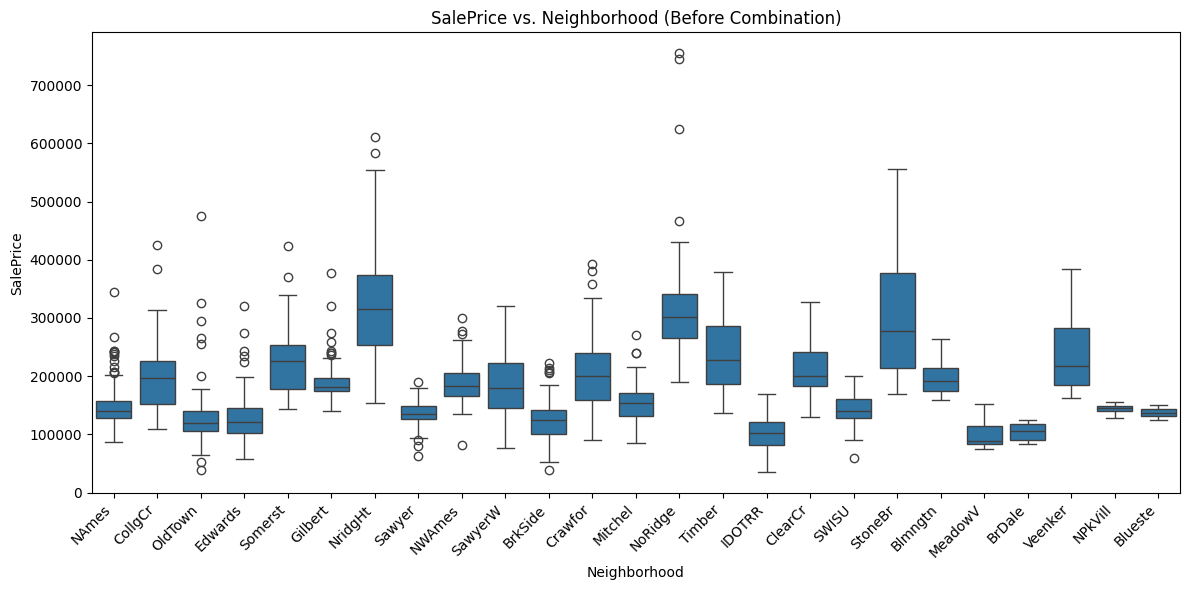

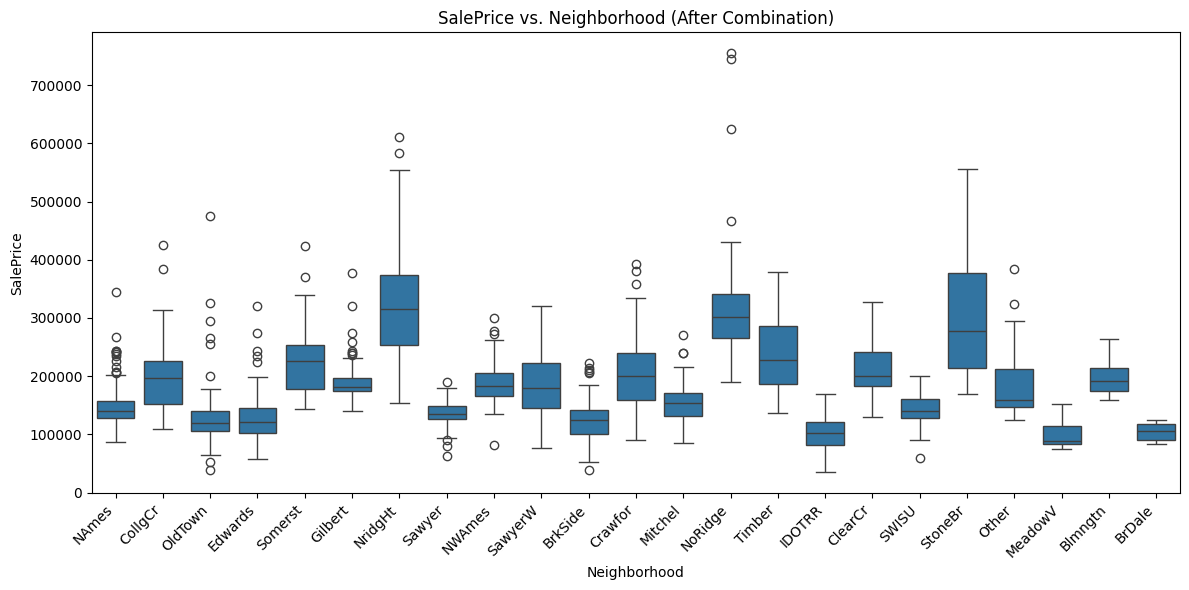

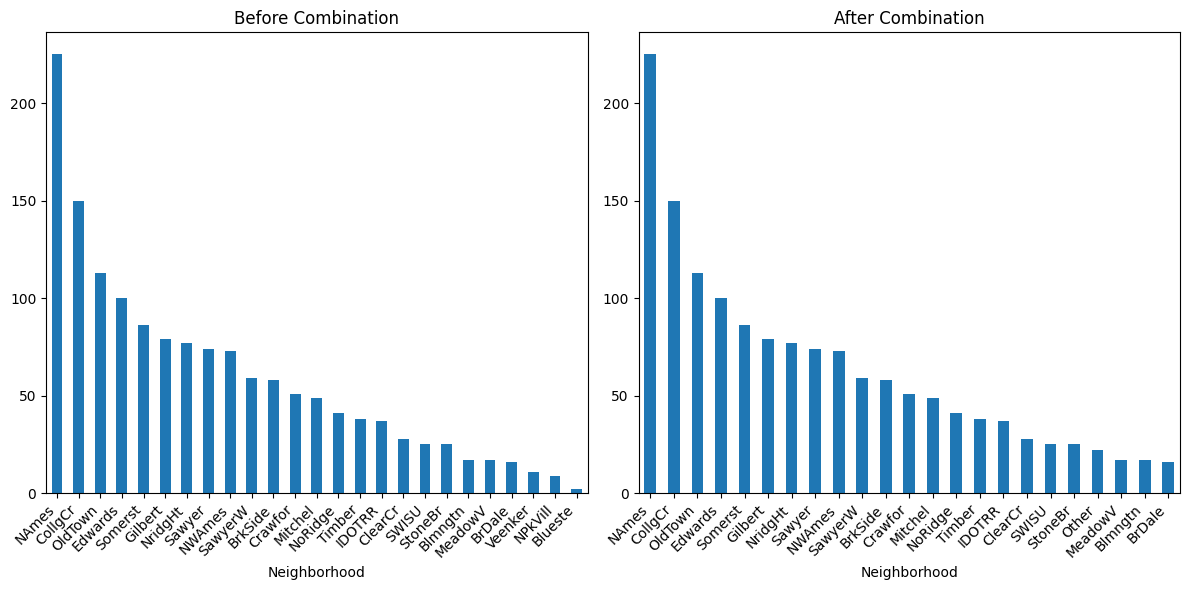

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feature_to_combine = 'Neighborhood'  # Replace with the name of your feature

threshold = 0.01 
value_counts = train_df[feature_to_combine].value_counts(normalize=True)
rare_categories = value_counts[value_counts < threshold].index.tolist()

print(f"Rare categories in '{feature_to_combine}': {rare_categories}")

train_df_copy = train_df.copy()

train_df_copy[feature_to_combine] = train_df_copy[feature_to_combine].apply(lambda x: 'Other' if x in rare_categories else x)

plt.figure(figsize=(12, 6))
sns.boxplot(x=feature_to_combine, y='SalePrice', data=train_df, order=train_df[feature_to_combine].value_counts().index)
plt.title(f'SalePrice vs. {feature_to_combine} (Before Combination)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x=feature_to_combine, y='SalePrice', data=train_df_copy, order=train_df_copy[feature_to_combine].value_counts().index)
plt.title(f'SalePrice vs. {feature_to_combine} (After Combination)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
train_df[feature_to_combine].value_counts().plot(kind='bar', title='Before Combination')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
train_df_copy[feature_to_combine].value_counts().plot(kind='bar', title='After Combination')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()